In [2]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from statistics import mean
from scipy.optimize import curve_fit
import scipy
import sys

sys.path.insert(0, './NUC')
from NUC_functions import create_NUC_df, collapse_df,compile_NUC_matrix_input,calc_NUC_coef

sys.path.insert(0, './radiometric')
from LUT_functions import pixel_registration, create_LUT_df
import scipy


In [3]:
#choose filepath to desired data
path = '/Volumes/KESU/chamber_data/'
cal_file2 =  "/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_files/cam1pixel.h5"
cal_file1 =  "/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_files/cam2pixel.h5"

In [4]:
#impoirt data from chamber scan
h5name = 'Left_0mm_neg35c-2.h5'
df = create_NUC_df(path, h5name)

In [5]:
'''fix wrapping error for temperatures '''
def correct_temps(df,key):
    for i in range(len(df[key])):
        if df[key][i] > 100:
            t1 = df[key][i]
            t2 =t1-6553.5
            df[key][i] = t2

In [6]:
correct_temps(df, "temps1")
correct_temps(df, "temps2")

<ipython-input-5-db8cc11e2fda>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key][i] = t2


In [7]:
#import nuc calibration
sys.path.insert(0, './NUC')
from NUC_functions import import_NUC, apply_NUC
cal_path = '/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_files/NUC.h5'

m1,b1,T_ref1,m2,b2,T_ref2 = import_NUC(cal_path)

In [8]:
#apply pixel registration and NUC to full dataset

ymin2 = 105; ymax2 = 140;
ymin1 = 130; ymax1 = 165;

waves= np.linspace(7,12,61)
angles = np.round(np.linspace(-7.07,7.07,35),1)

#will create a df and print the names of the keys in the original hdf5 file
corrected_images1= [] ; corrected_images1n= [];
corrected_images2= [] ; corrected_images2n= []

for i in range(20):
    r1 = df['imgs1'][i];
    c1 = pixel_registration(r1,cal_file1,waves,ymin1,ymax1)
        
    #now with NUC correction
    T1 = df['temps1'][i];
    rn1 = apply_NUC(r1,T1,m1,b1,T_ref1)
    cn1 = pixel_registration(rn1,cal_file1,waves,ymin1,ymax1)
        
    corrected_images1.append(c1)
    corrected_images1n.append(cn1)
    
    r2 = df['imgs2'][i];
    c2 = pixel_registration(r2,cal_file2,waves,ymin2,ymax2)
        
    #now with NUC correction
    T2 = df['temps2'][i];
    rn2 = apply_NUC(r2,T2,m2,b2,T_ref2)
    cn2 = pixel_registration(rn2,cal_file2,waves,ymin2,ymax2)
        
    corrected_images2.append(c2)
    corrected_images2n.append(cn2)

    

In [79]:
#import radiometric data

#choose filepath to desired data
save_path =   '/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_files/'
name =  "LUT.h5" 

hf = h5py.File(save_path+name, 'r')
B1 = hf.get('B2')
B2 = hf.get('B1')

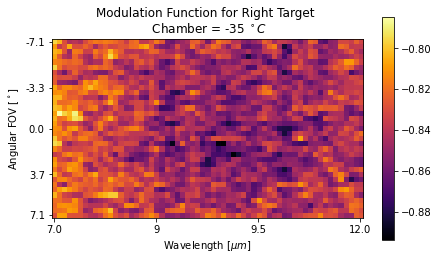

In [92]:
j = 1;
I1 = corrected_images1[j] 
I2 = corrected_images2[j] 
plt.matshow((((I1-I2)/(I1+I2)))*42,cmap = 'inferno' )
plt.colorbar()
plt.ylabel('Angular FOV [$^\circ$]')
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.yticks([0, 9,17,26,34], [angles[0], angles[9],angles[17],angles[26],angles[34]])
plt.title('Modulation Function for Right Target \n Chamber = -35 $^\circ C$ ')
#plt.clim([-.1,.1])
plt.show()
